In [2]:
import sys
import os
import numpy as np
import pickle
import tensorflow as tf
import gpflow
sys.path.append('../../../../')
import gpitch
from gpitch.amtgp import logistic
from gpitch import myplots

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']= (16, 3)

In [4]:
active_device = sys.argv[1]  # configure gpu usage and plotting
gpitch.amtgp.init_settings(visible_device = active_device, interactive=True)

In [5]:
saveloc = '../../../../../results/files/svi/notebook/'
dirloc = '../../../../../datasets/maps/sample_rate_16khz/'
pattern = '*F*.wav'
bounds = [21, 109]
midi = np.asarray([str(i) for i in range(bounds[0], bounds[1])]).reshape(-1,)
filel = gpitch.amtgp.load_filenames(directory=dirloc, pattern=pattern, bounds=bounds)
Np = filel.size  # number of pitches to analyze

In [6]:
fs = 16e3  # sample frequency
N = 16000  # number of data points to load
x = np.linspace(0, (N-1.)/fs, N).reshape(-1, 1)  # time vector
Nc = 10  #  number of harmonics for component kernels
dec = 160  # decimation factor
minibatch_size = 200
maxiter = 2000
learning_rate = 0.01
maxh = 20  # max number of harmoncis in component kernel

In [7]:
Y = np.zeros((N, Np))
ideal_f0 = np.zeros((Np,1))
Fs = [None]*Np
Ss = [None]*Np 
F  = np.zeros((N//2, 1))
S  = np.zeros((N//2, Np))
thres = np.zeros((Np, 1))

In [8]:
for i in range(0, Np):  # load data
    y, fs = gpitch.amtgp.wavread(dirloc + filel[i], start=5000, N=N)  # load data       
    Y[:, i] = y.reshape(-1,).copy()
    ideal_f0[i] = gpitch.amtgp.midi2frec(int(midi[i]))
    
    Fs[i], Ss[i], F[:, 0], S[:, i], thres[i] = gpitch.amtgp.init_com_params(y=y, fs=fs, 
                                                                               maxh=maxh, 
                                                                               ideal_f0=ideal_f0[i],
                                                                               scaled=True, 
                                                                               win_size=10)

/home/paad/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


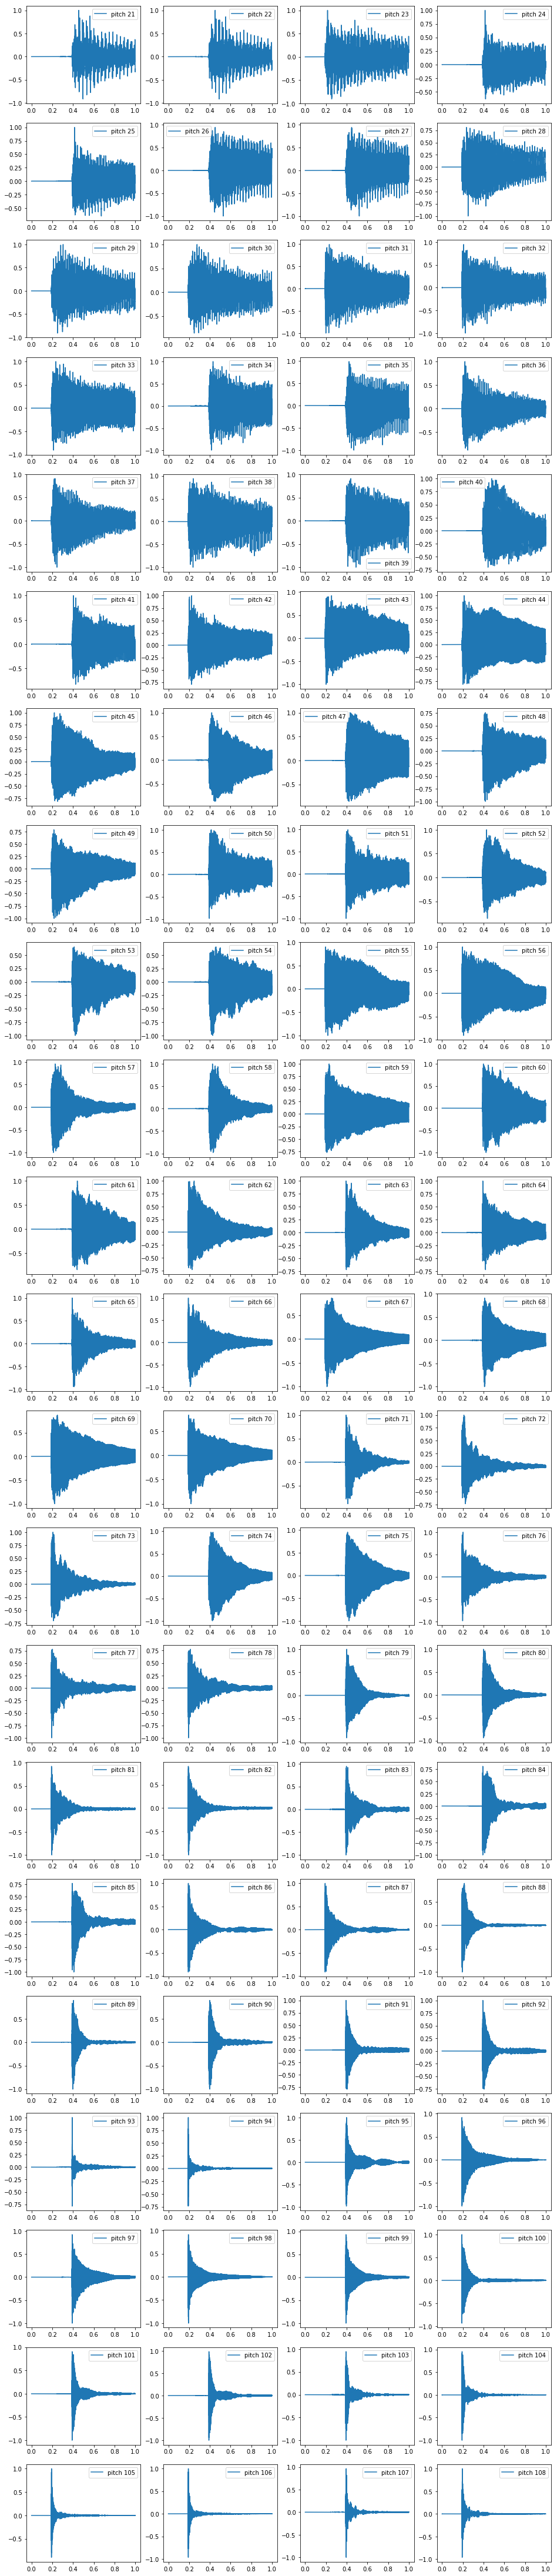

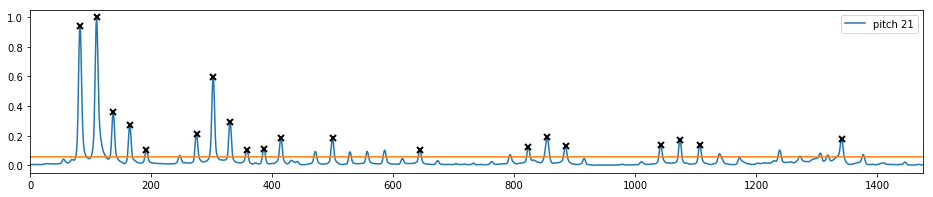

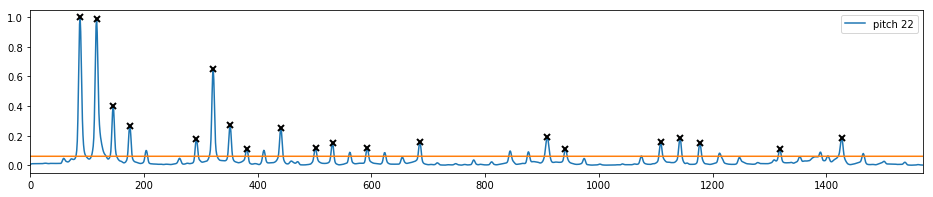

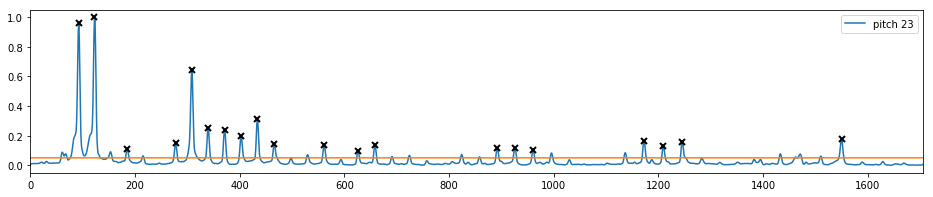

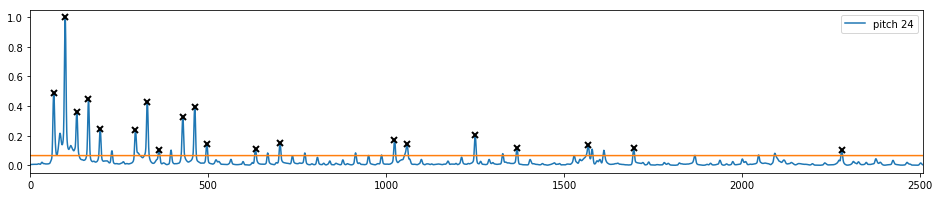

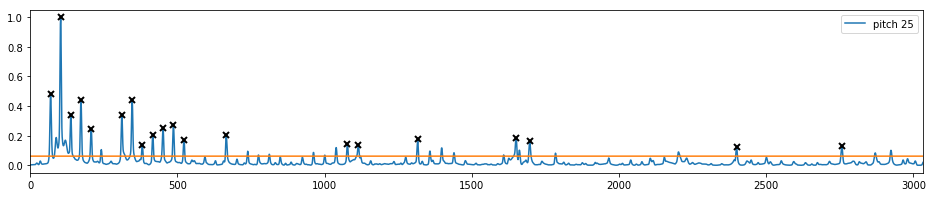

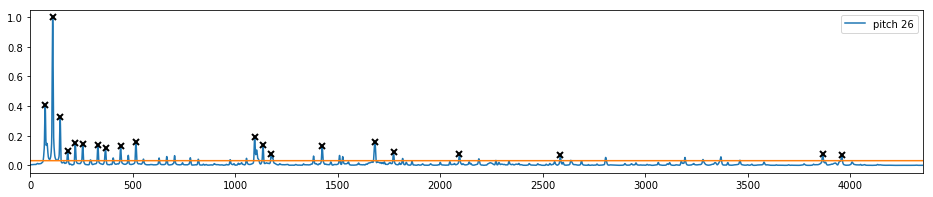

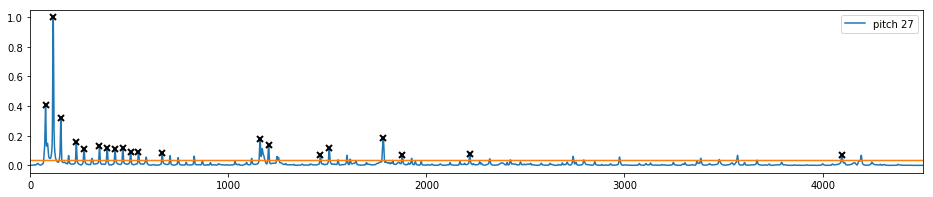

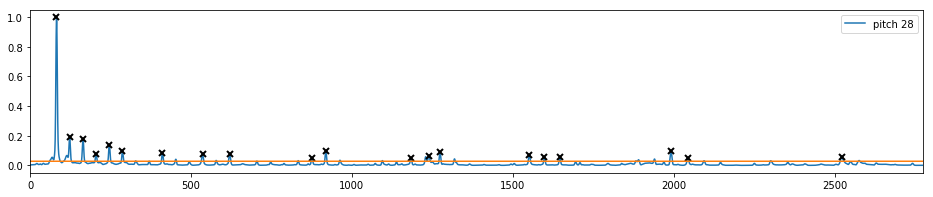

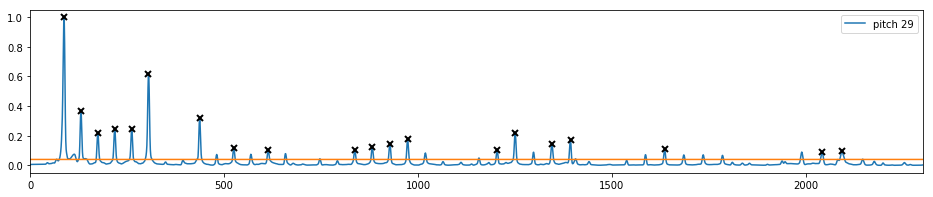

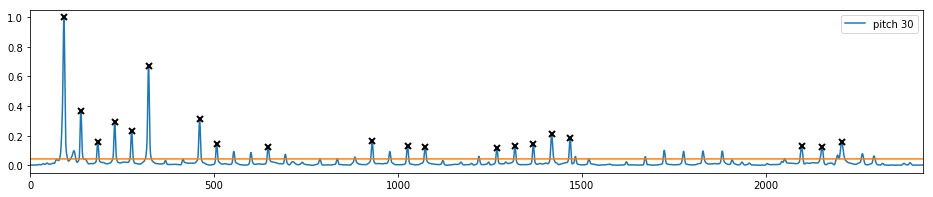

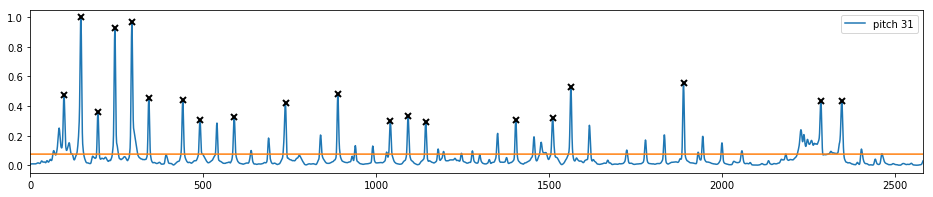

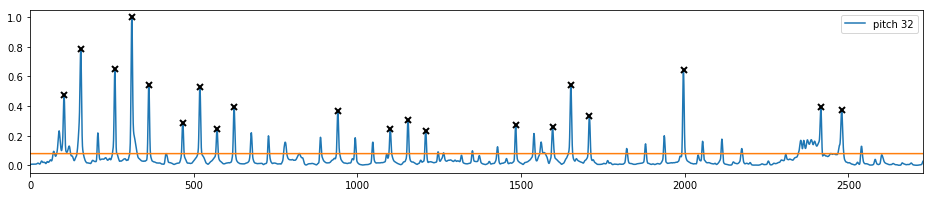

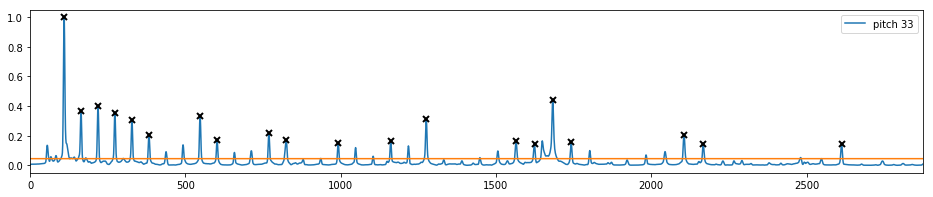

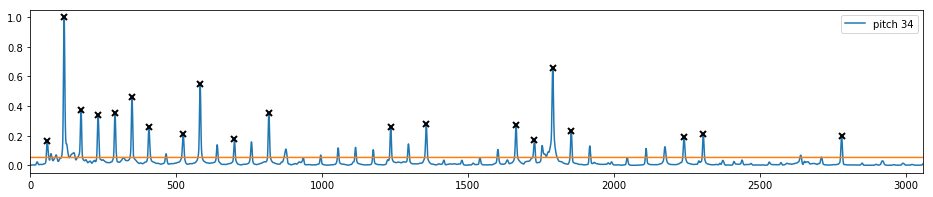

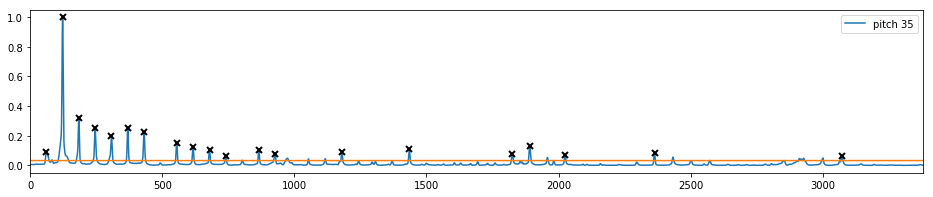

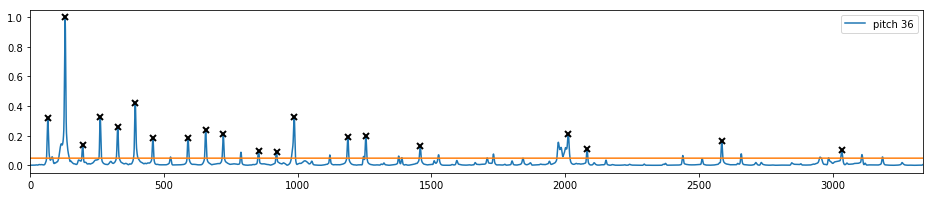

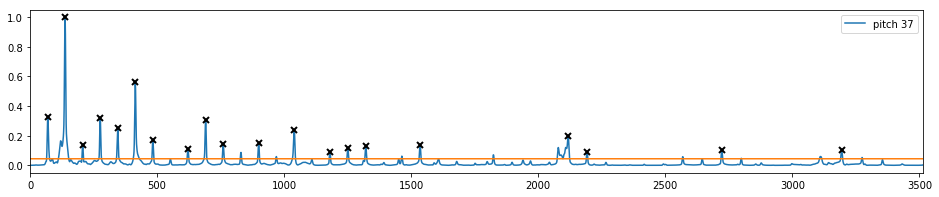

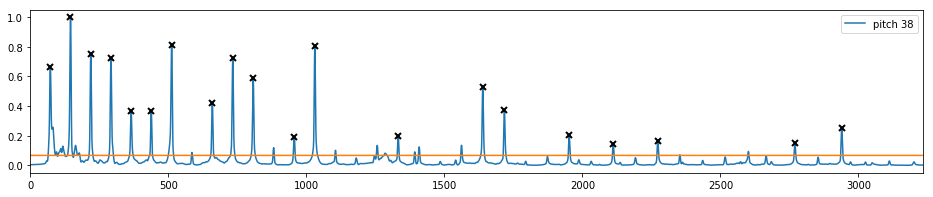

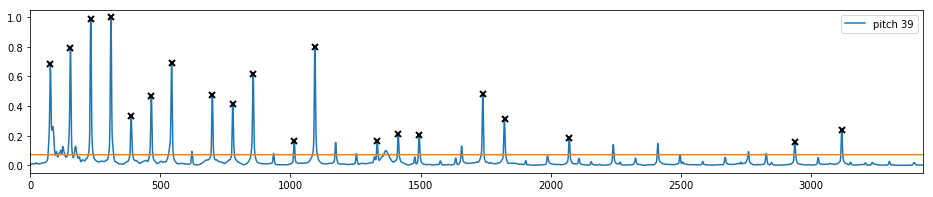

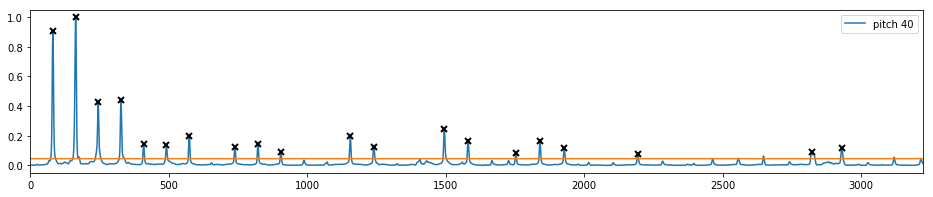

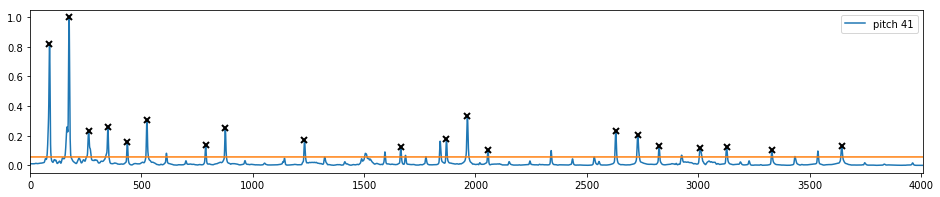

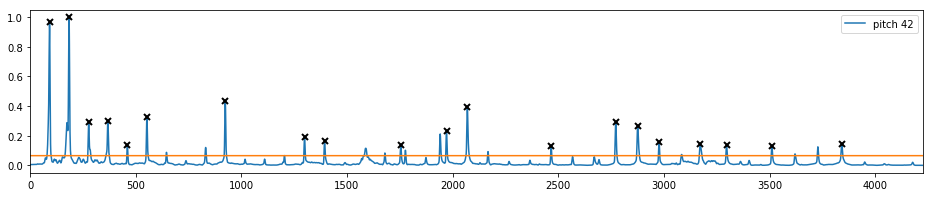

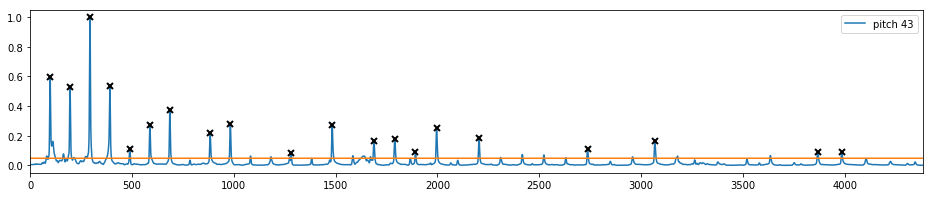

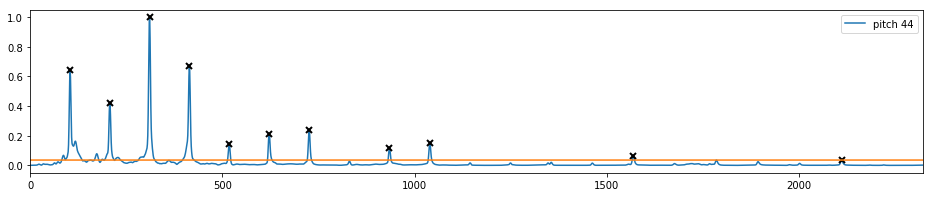

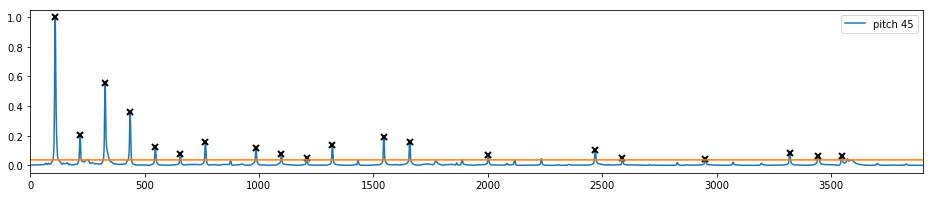

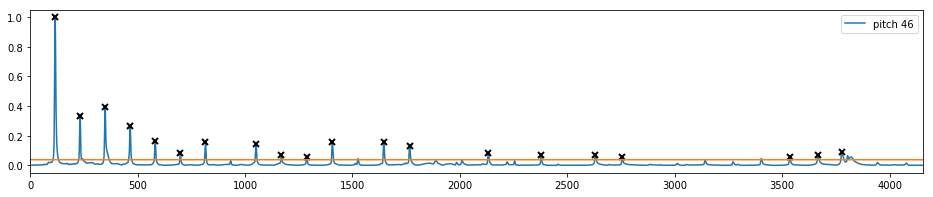

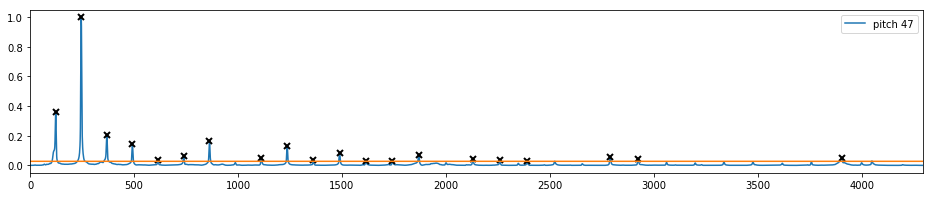

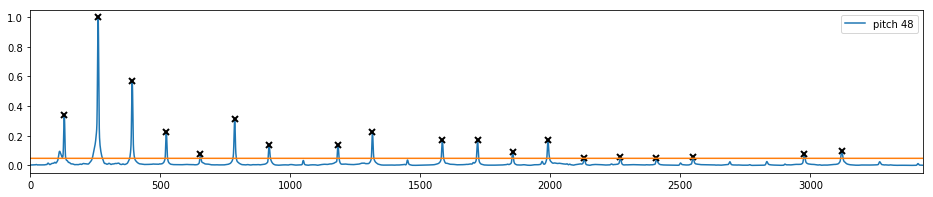

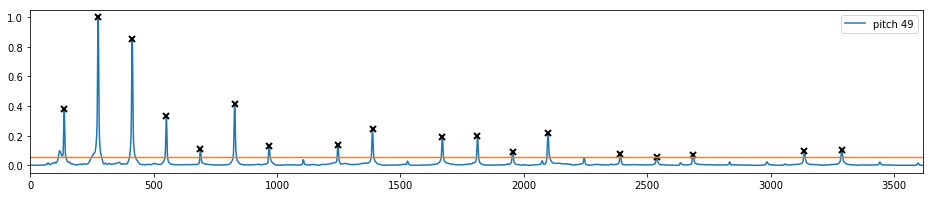

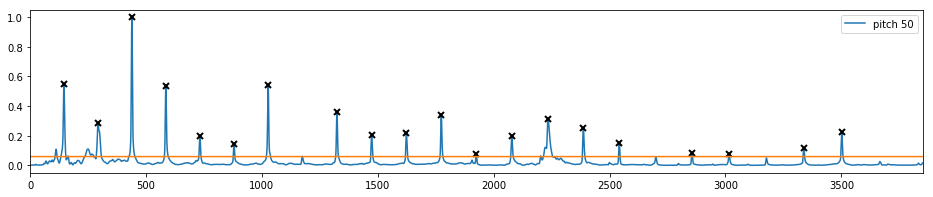

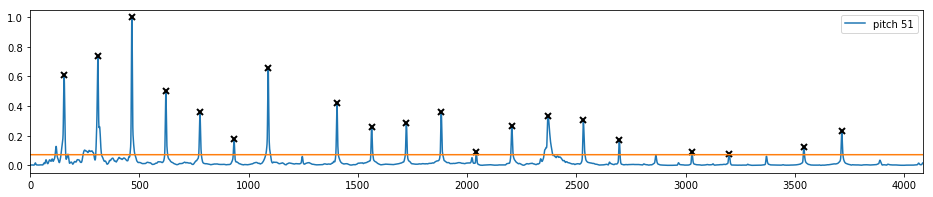

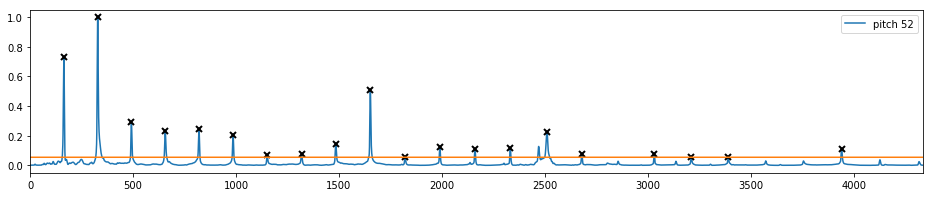

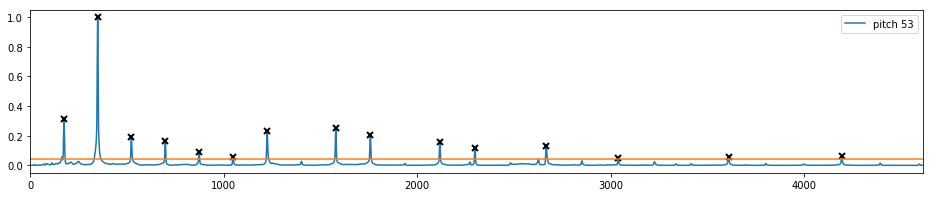

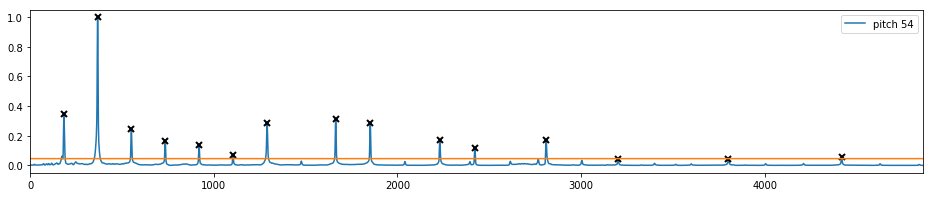

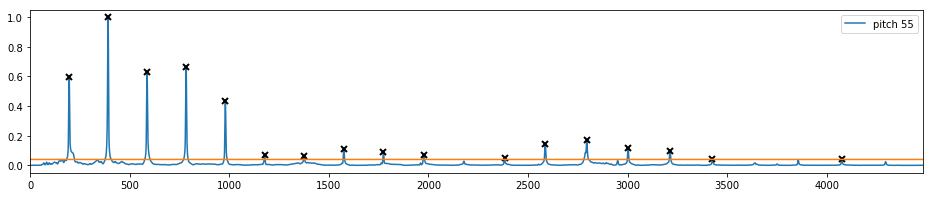

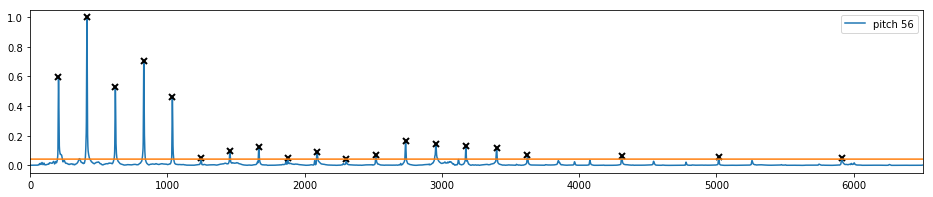

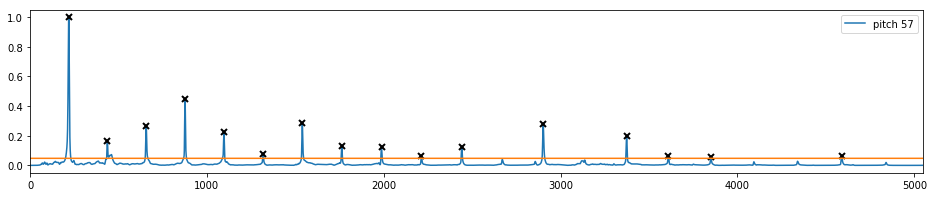

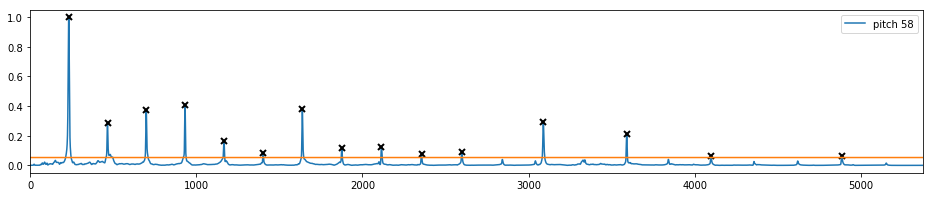

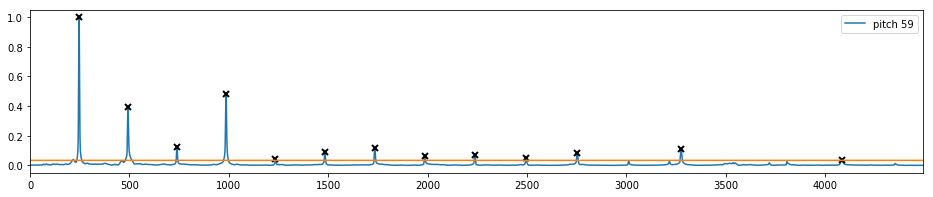

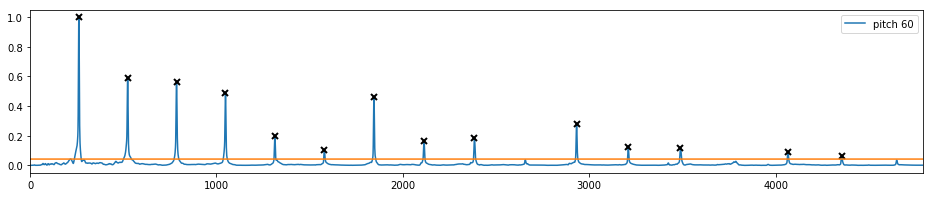

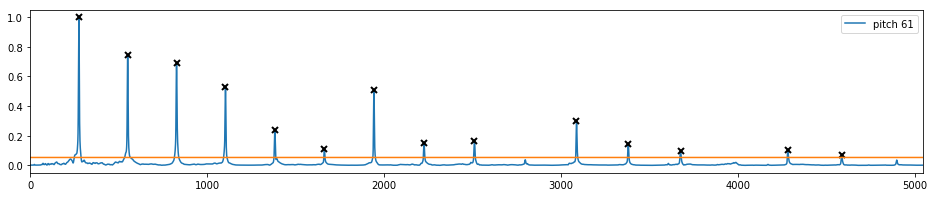

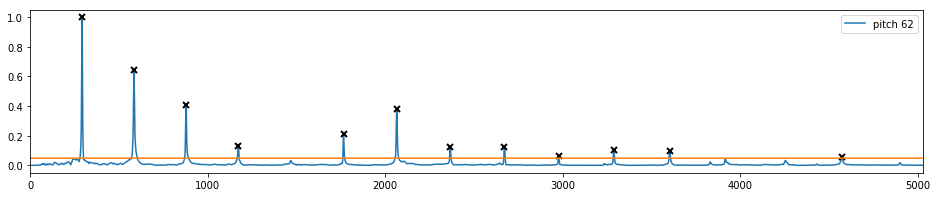

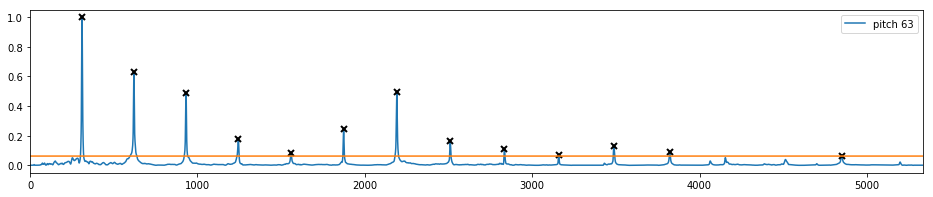

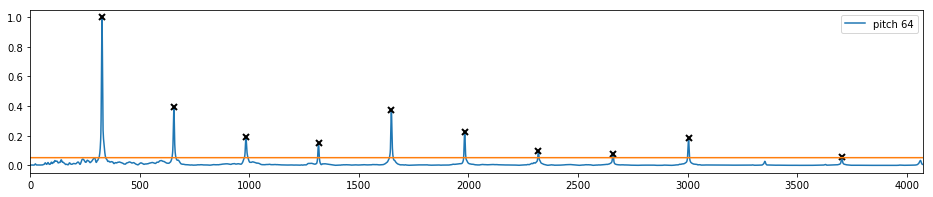

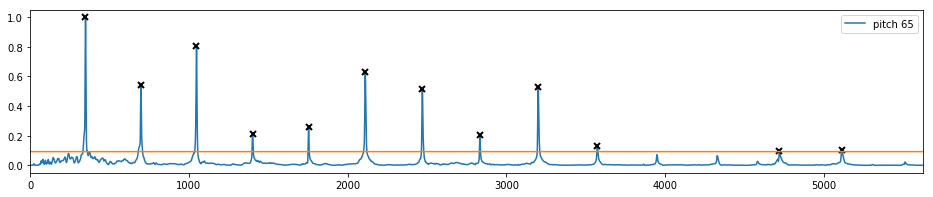

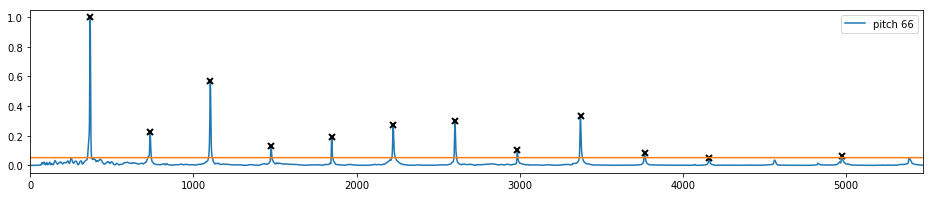

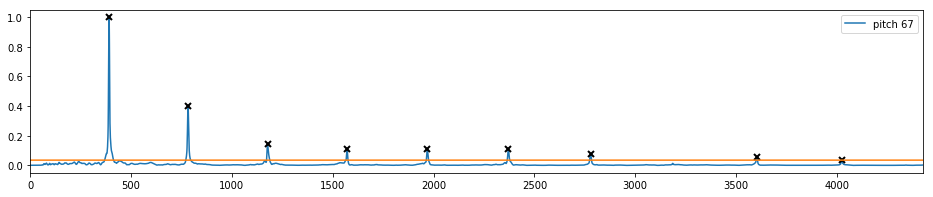

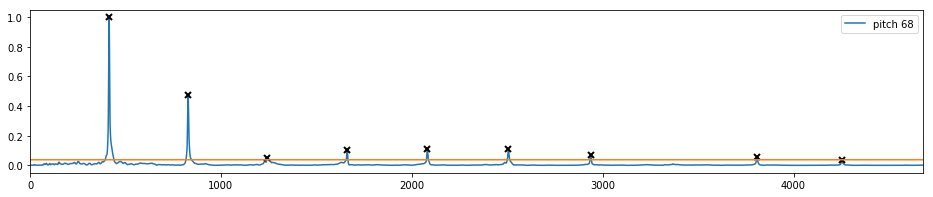

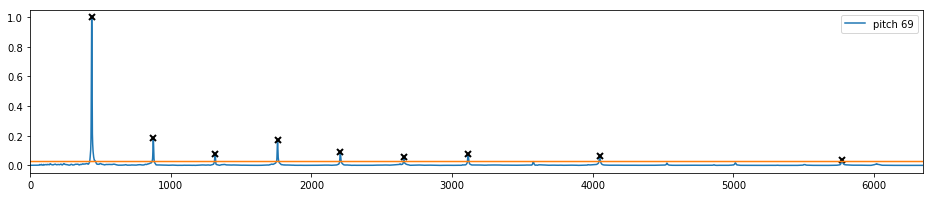

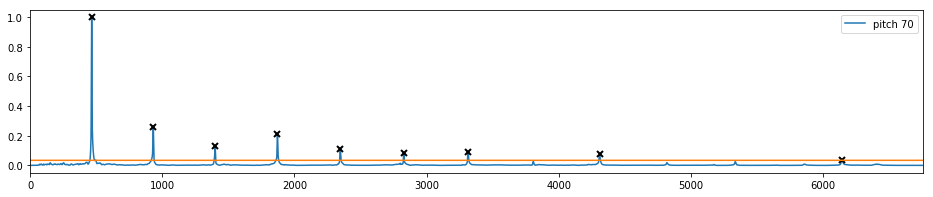

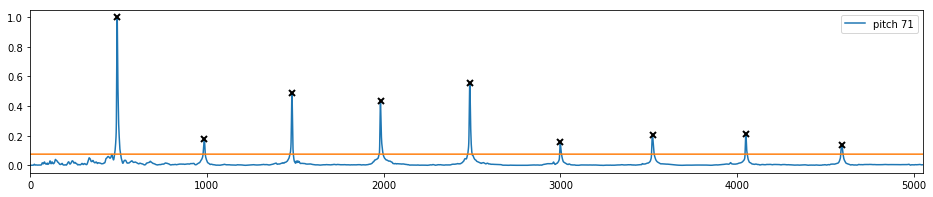

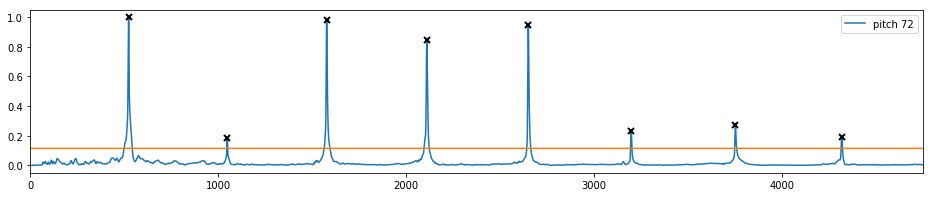

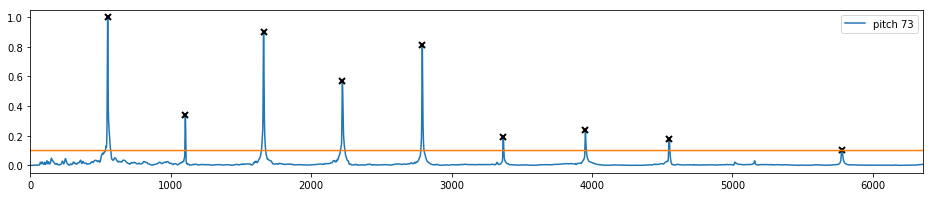

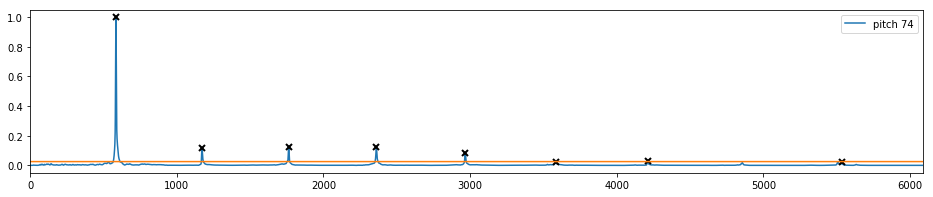

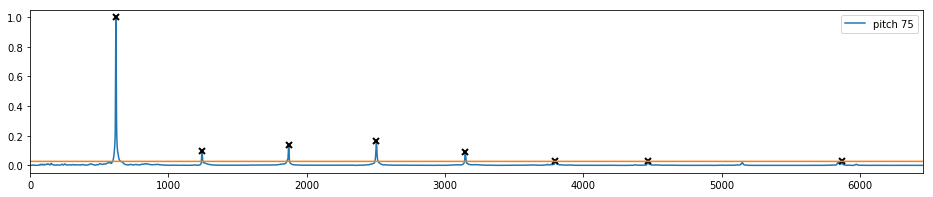

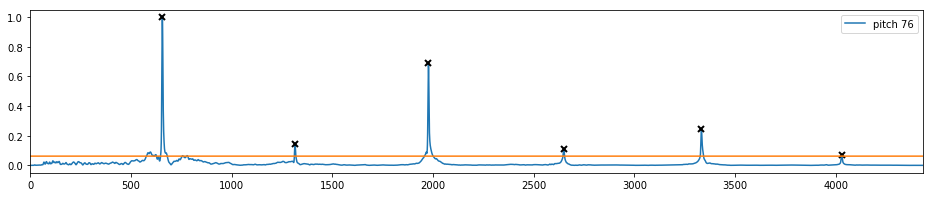

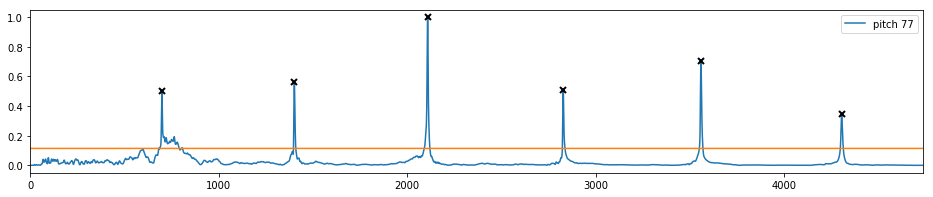

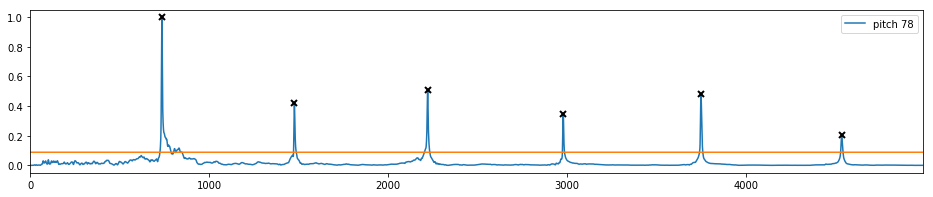

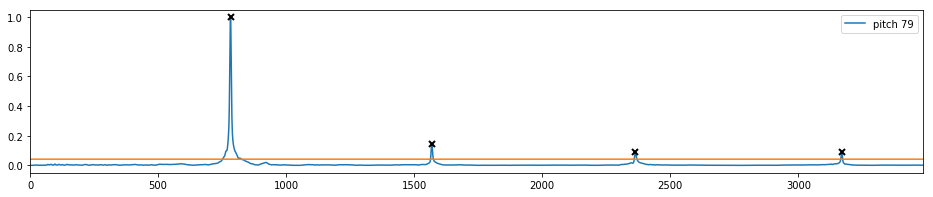

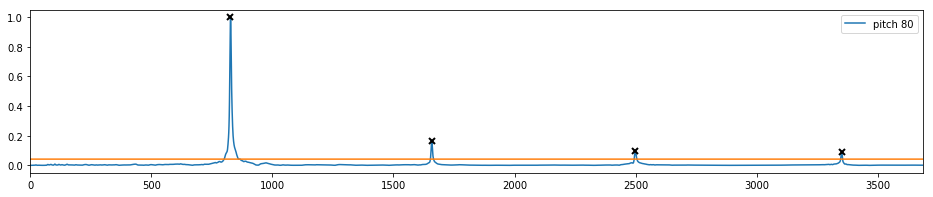

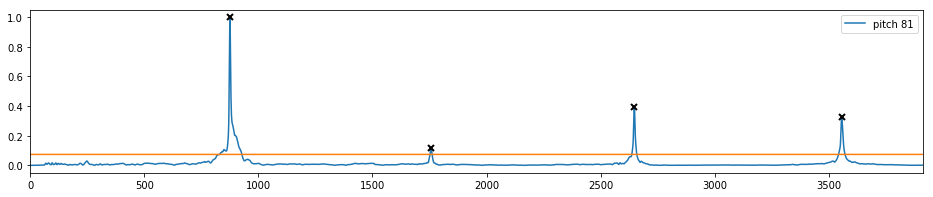

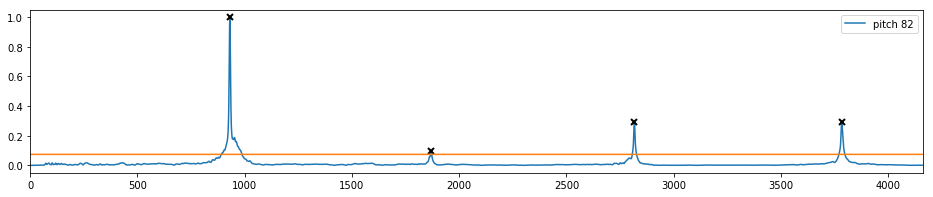

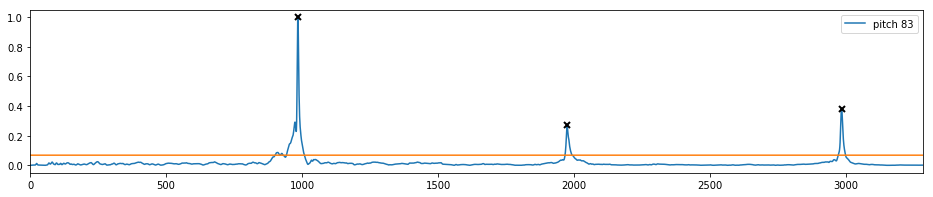

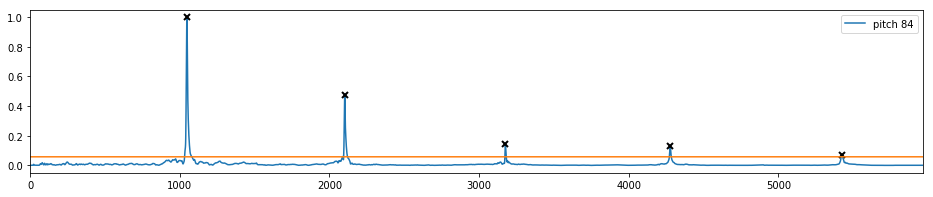

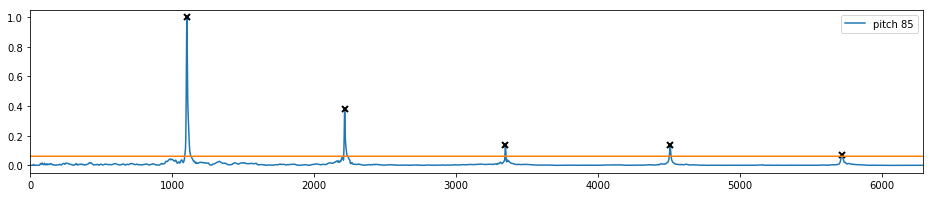

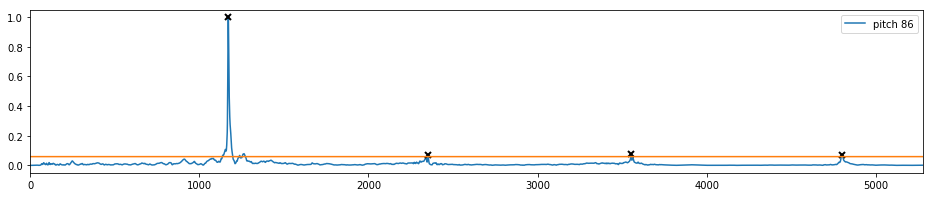

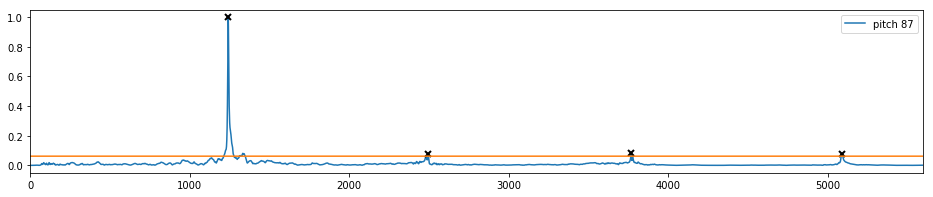

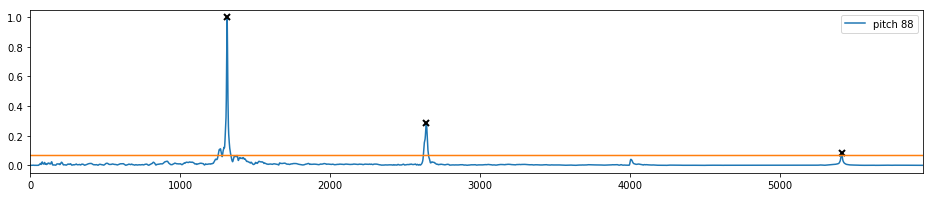

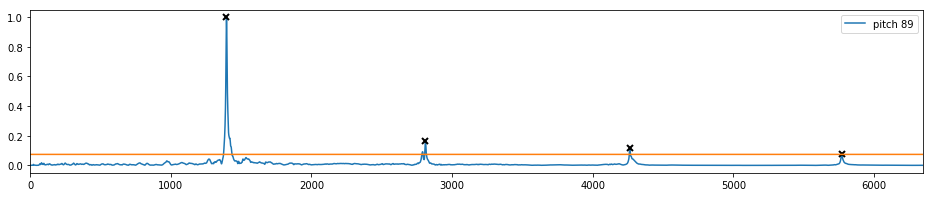

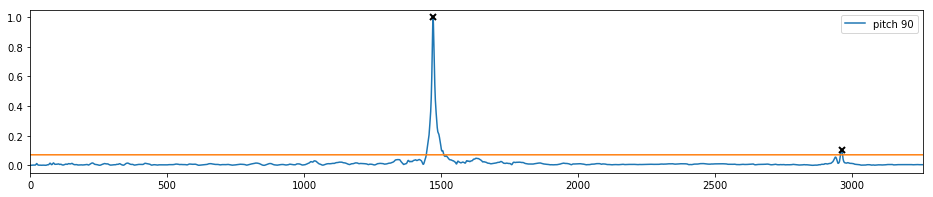

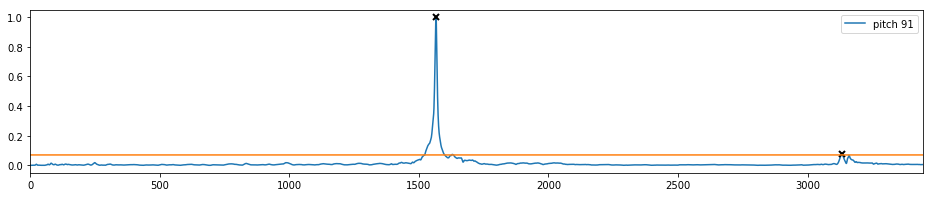

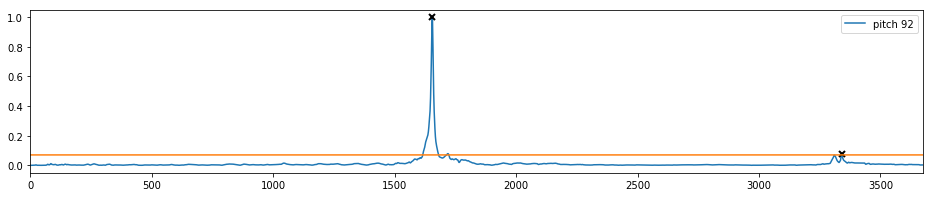

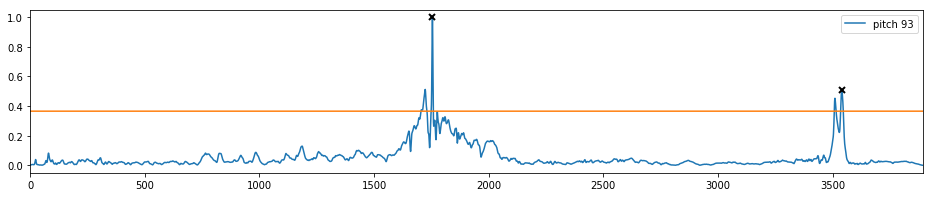

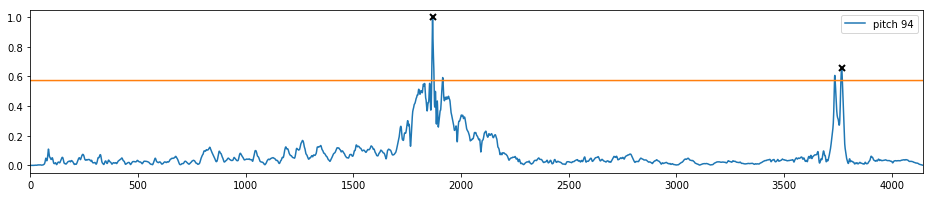

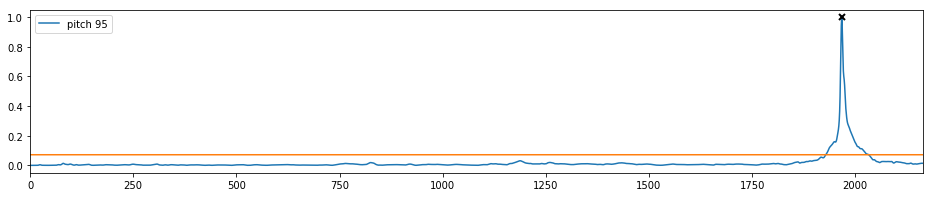

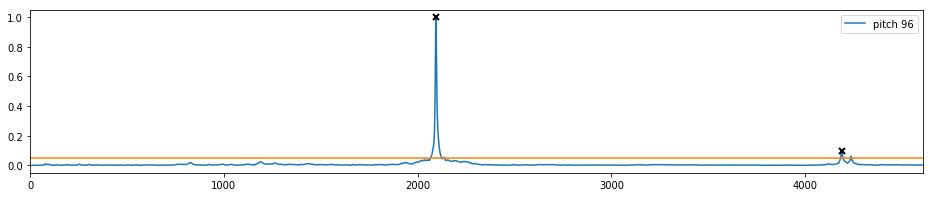

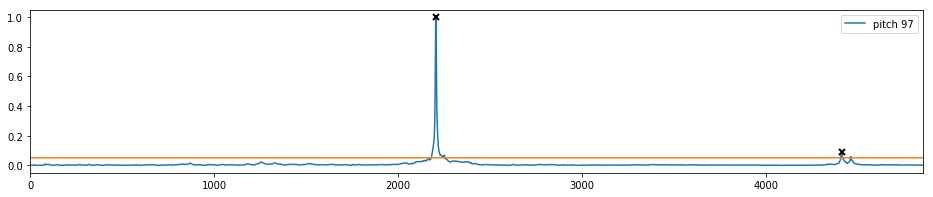

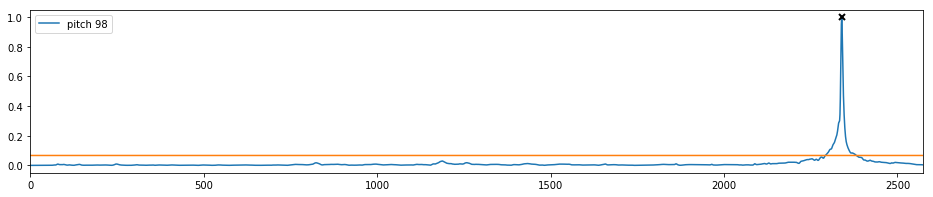

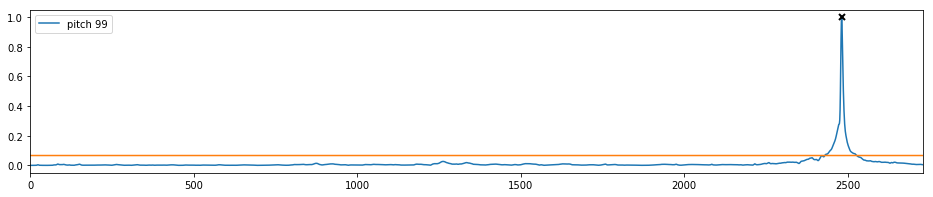

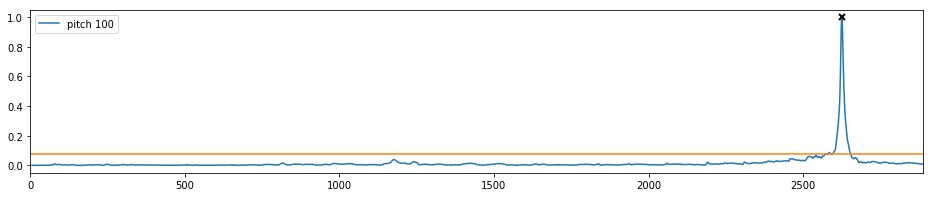

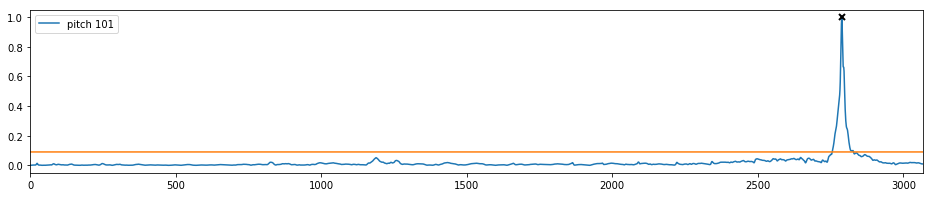

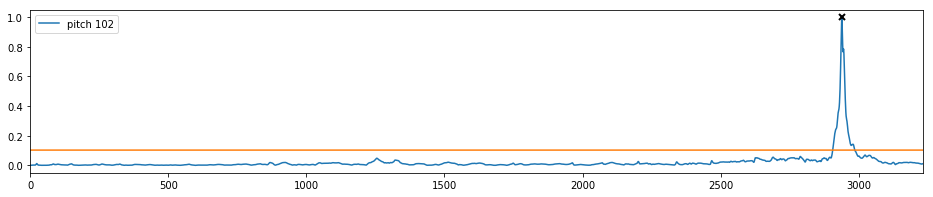

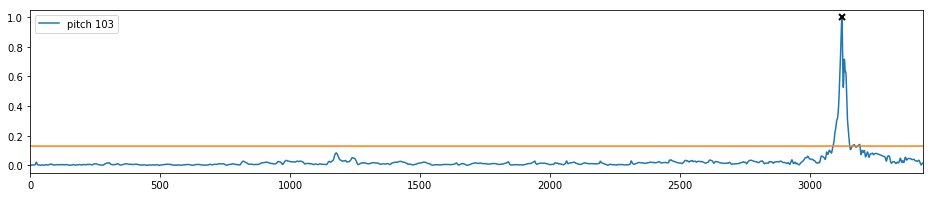

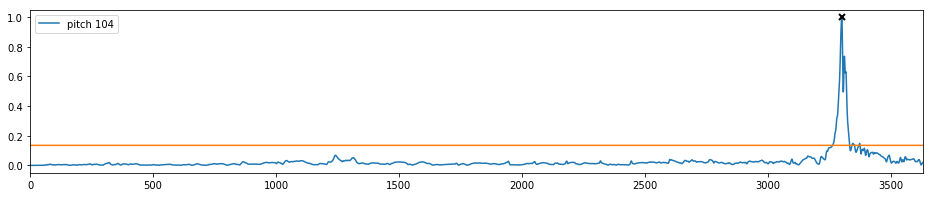

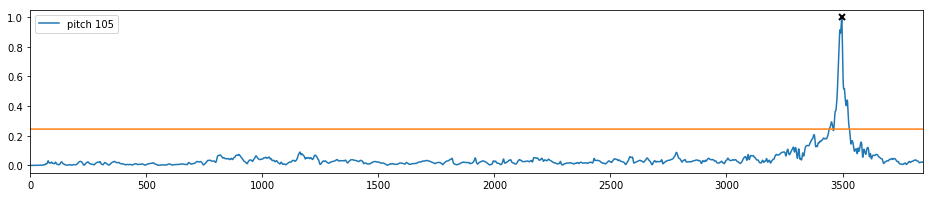

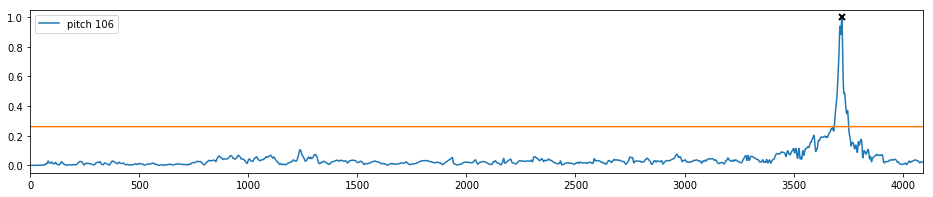

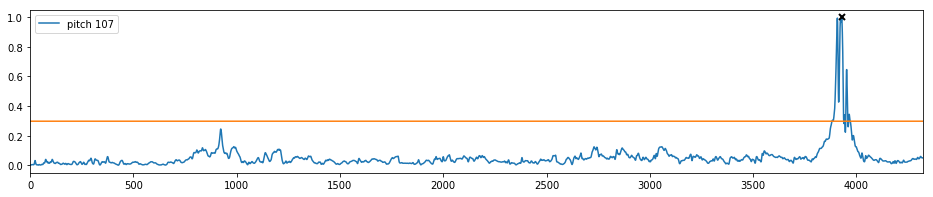

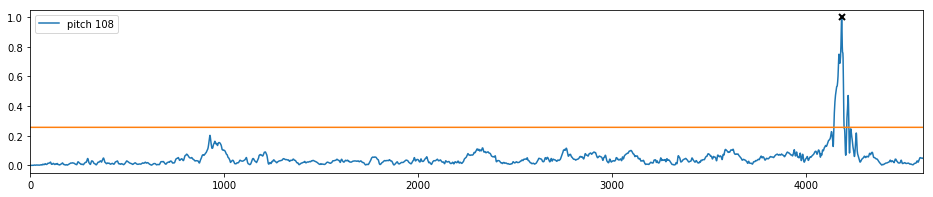

In [9]:
plt.figure(1, figsize=(16, 80))  
plt.figure(2, figsize=(16, 80))
nrow, ncol = 22, 4
for i in range(0, Np):
    y = Y[:, i].reshape(-1,1).copy()
    
    plt.figure(1)
    plt.subplot(nrow, ncol, i+1)
    plt.plot(x, y)
    plt.legend(['pitch ' + midi[i]])
         
    plt.figure()
    plt.plot(F, S[:,i]/ np.max(S[:,i]))
    plt.plot(Fs[i], Ss[i]/np.max(Ss[i]), 'xk', mew=2)
    plt.plot(F, 0.*S[:,i] + thres[i])
    plt.legend(['pitch ' + midi[i]])
    plt.xlim([0, 1.1*np.max(Fs[i])])

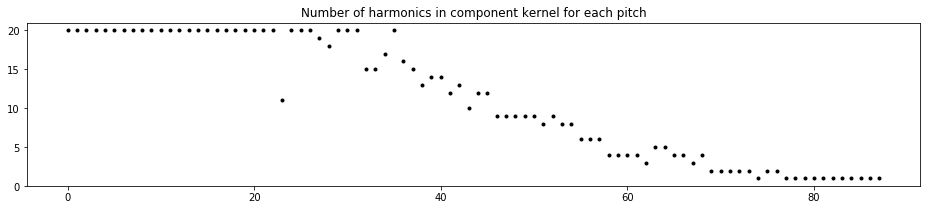

In [10]:
plt.figure(),  plt.title('Number of harmonics in component kernel for each pitch')
for i in range(Np):
    plt.plot(i, Fs[i].size, '.k')

In [ ]:
for i in range(Np):
    y = Y[:, i].reshape(-1,1).copy()
    z = np.vstack((x[::dec].copy(), x[-1].copy()))
    
    kern_com = gpitch.kernels.MaternSpecMix(input_dim=1, lengthscales=0.1, variances=Ss[i],
                                            frequencies=Fs[i], Nc=Fs[i].size)
    kern_act = gpflow.kernels.Matern32(input_dim=1, lengthscales=0.25, variance=10.)

    m = gpitch.modgp.ModGP(x=x, y=y, z=z, kern_com=kern_com, kern_act=kern_act, whiten=True,
                           minibatch_size=minibatch_size)
    
    m.fixed_msmkern_params(freq=False, var=True)
    m.kern_com.lengthscales.fixed = False
    m.kern_com.lengthscales.transform = gpflow.transforms.Logistic(0., 10.0)
    m.kern_act.fixed = False
    m.likelihood.variance.fixed = False
    m.z.fixed = True
    print('learning from ' + filel[i])
    m.optimize_svi(maxiter=maxiter, learning_rate=learning_rate)
    pickle.dump(m, open(saveloc + "maps_pitch_" + midi[i] + ".p", "wb"))
    tf.reset_default_graph()